In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [26]:
digits=datasets.load_digits()
#digits.data has 1797 images and each image has 64 features
print(digits.data.shape)
#digits.images has 1797 images as a 2d tensor of 8*8 size
print(digits.images.shape)
#digits.target has 1797 image classification
print(digits.target.shape)

(1797, 64)
(1797, 8, 8)
(1797,)


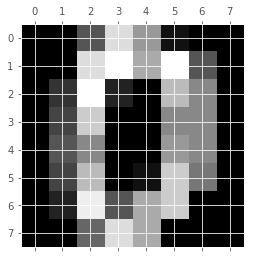

In [27]:
#let's plot the first image
plt.gray() 
plt.matshow(digits.images[0]) 

In [40]:
#lets scale the data
from sklearn.preprocessing import scale
data=scale(digits.data)
print(data)

[[ 0.         -0.33501649 -0.04308102 ..., -1.14664746 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ...,  0.54856067 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ...,  1.56568555  1.6951369
  -0.19600752]
 ..., 
 [ 0.         -0.33501649 -0.88456568 ..., -0.12952258 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -0.67419451 ...,  0.8876023  -0.5056698
  -0.19600752]
 [ 0.         -0.33501649  1.00877481 ...,  0.8876023  -0.26113572
  -0.19600752]]


In [41]:
#let's reduce dimensions of scaled data using PCA
import numpy as np
from sklearn.decomposition import PCA

data_x=data
data_Y=digits.target

In [53]:
pca = PCA(n_components=2)
reduced_x=pca.fit_transform(digits_x)

In [54]:
reduced_x.shape #the new feature space has 10 features

(1797, 2)

In [55]:
n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 10, 	 n_samples 1797, 	 n_features 64


In [56]:
#apply k-means clusturing on reduced scaled data
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [57]:
#see the lebels
kmeans.labels_

array([6, 0, 7, ..., 7, 8, 4], dtype=int32)

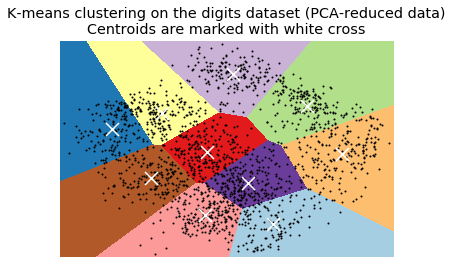

In [58]:
from sklearn import metrics
import numpy as np
from time import time

#visualizing the clusters
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_x[:, 0].min() - 1, reduced_x[:, 0].max() + 1
y_min, y_max = reduced_x[:, 1].min() - 1, reduced_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_x[:, 0], reduced_x[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [66]:
#now lets split the dataset to train and test set
from sklearn.cross_validation import train_test_split
data_train, data_test, target_train, target_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

In [67]:
# now lets see the shape of tain and test data
print(data_train.shape)
print(data_test.shape)
print(target_train.shape)
print(target_test.shape)

(1437, 64)
(360, 64)
(1437,)
(360,)


In [161]:
# lets use support vector mechine to classify the data
#first lets define a function

from sklearn import svm, grid_search
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf',probability=True), param_grid, cv=nfolds, verbose=1,scoring='neg_log_loss')
    grid_search.fit(X, y)
    print ('Best score: %0.3f' % grid_search.best_score_)
    print("Best params: ")
    print(grid_search.best_params_)
    return grid_search

In [163]:
#let's define another function that tests aour test set on the best estimator and do an ROC plot

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
def plot_roc(model,X):
    y_true,y_pred=target_test, model.predict_proba(X)
    
    # let's one hot encode the test target value 
    y_true_binary = label_binarize(target_test, classes=[0,1,2,3,4,5,6,7,8,9])
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_true_binary[0])):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(y_true_binary[0]))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(y_true_binary[0])):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(y_true_binary[0])

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    lw = 2

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','aqua', 'darkorange', 'cornflowerblue','aqua', 'darkorange', 'cornflowerblue','aqua'])
    for i, color in zip(range(len(y_true_binary[0])), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [172]:
#lets train our train set with 2fold cross validation so total 40 sets of parameters will be tested
model=svc_param_selection(data_train,target_train,2)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   34.3s finished


Best score: -0.145
Best params: 
{'C': 10, 'gamma': 0.001}


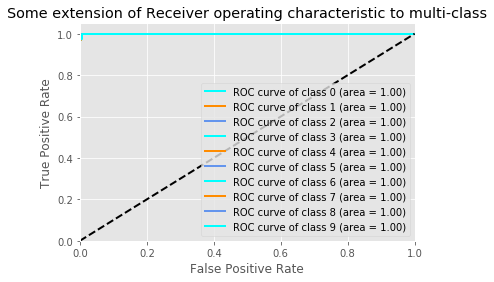

In [173]:
#let's plot the ROC curve by predicting on test data set
plot_roc(model,data_test)

Total number of features:  10
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   16.2s finished


Best score: -0.175
Best params: 
{'C': 10, 'gamma': 0.001}


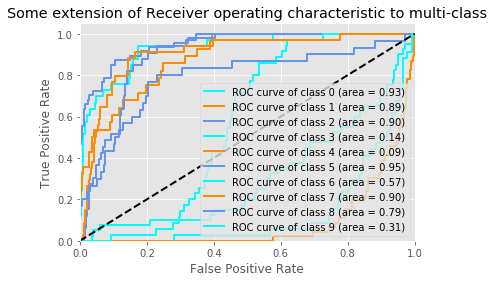

Total number of features:  20
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   20.0s finished


Best score: -0.147
Best params: 
{'C': 10, 'gamma': 0.001}


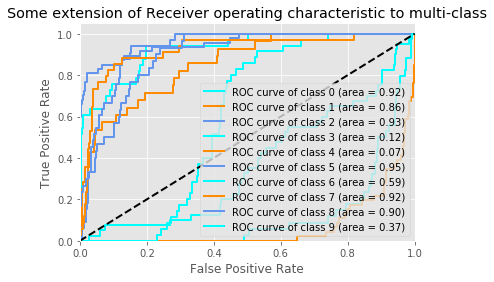

Total number of features:  40
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   26.5s finished


Best score: -0.145
Best params: 
{'C': 10, 'gamma': 0.001}


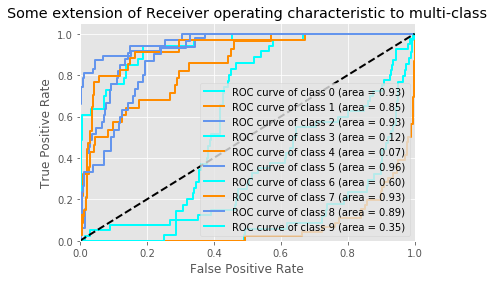

Total number of features:  60
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   33.9s finished


Best score: -0.146
Best params: 
{'C': 10, 'gamma': 0.001}


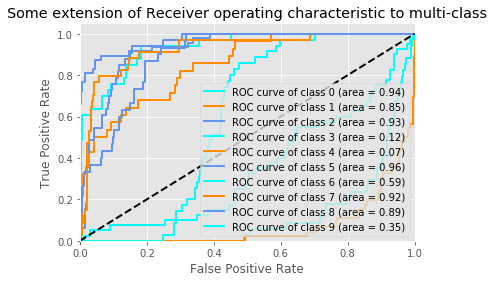

Total number of features:  64
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   34.9s finished


Best score: -0.144
Best params: 
{'C': 10, 'gamma': 0.001}


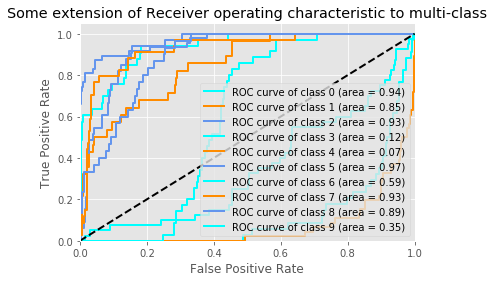

In [171]:
#now lets apply PCA to reduce dimension and check the model performance and compare the ROC curve
for i in(10,20,40,60,64):
    pca = PCA(n_components=i)
    reduced_data_train=pca.fit_transform(data_train)
    reduced_data_test=pca.fit_transform(data_test)
    print("Total number of features: ", i)
    model=svc_param_selection(reduced_data_train,target_train,2)
    plot_roc(model,reduced_data_test)